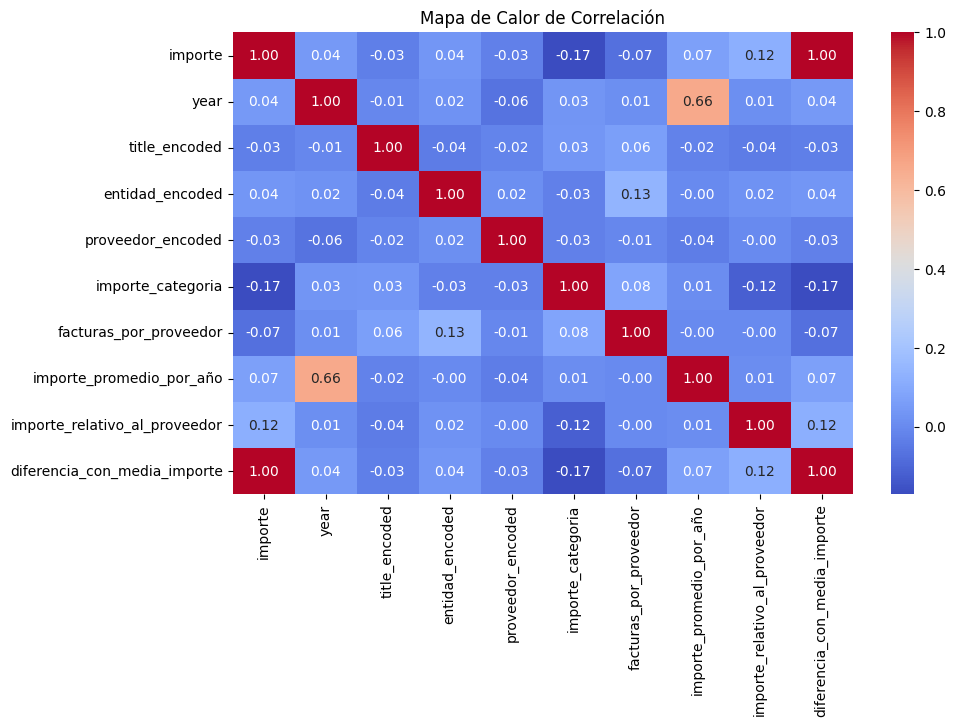

Métricas de Clasificación:
Accuracy: 0.73
              precision    recall  f1-score   support

        alto       0.72      0.74      0.73       376
        bajo       0.85      0.80      0.83      1289
       medio       0.35      0.42      0.39       328
         nan       0.22      0.29      0.25         7

    accuracy                           0.73      2000
   macro avg       0.54      0.56      0.55      2000
weighted avg       0.74      0.73      0.73      2000



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle
from imblearn.over_sampling import SMOTE


df = pd.read_csv("facturas_procesadas.csv")

# eliminar filas nulas
df = df[df["importe_categoria"] != "nan"]

# convertir a string
df["importe_categoria"] = df["importe_categoria"].astype(str)

# seleccionar  X e y
X_clasificacion = df.drop(columns=["importe", "importe_categoria"])
y_clasificacion = df["importe_categoria"]

# verificar correlaciones con importe_categoria para evitar informacion redundante
df_encoded = df.copy()
df_encoded["importe_categoria"] = df_encoded["importe_categoria"].astype("category").cat.codes

plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Calor de Correlación")
plt.show()

# eliminar alguna columna correlacionada con "importe_categoria"
columnas_eliminar = ["importe_relativo_al_proveedor", "diferencia_con_media_importe"]
X_clasificacion = X_clasificacion.drop(columns=columnas_eliminar, errors="ignore")

# dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_clasificacion, y_clasificacion, test_size=0.2, random_state=42)

# aplicar smote en el conjunto de entrenamiento
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# manejar valores nulos en X_train
for col in X_train_smote.columns:
    if X_train_smote[col].isnull().sum() > 0:
        if X_train_smote[col].dtype == "object":
            X_train_smote[col].fillna(X_train_smote[col].mode()[0], inplace=True)
        else:
            X_train_smote[col].fillna(X_train_smote[col].mean(), inplace=True)


y_train_smote.fillna(y_train_smote.mode()[0], inplace=True)
y_train_smote = y_train_smote.astype(str)
y_test = y_test.astype(str)

# entrenar el modelo de clasificacion
modelo_clasificacion = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
modelo_clasificacion.fit(X_train_smote, y_train_smote)

# hacer predicciones y evaluar el modelo
y_pred = modelo_clasificacion.predict(X_test)

print("Métricas de Clasificación:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

with open("modelo_clasificacion.pkl", "wb") as f:
    pickle.dump(modelo_clasificacion, f)



